In [1]:
# ==== Cell 1: Config ====
# If you saved Task-1 output 'loan_clean_subset.csv', you can set USE_CLEAN_FIRST=True.
USE_CLEAN_FIRST = True

# Path to raw file (if we need to preprocess end-to-end)
# Colab: upload the file in /content
FILE_PATH = "accepted_2007_to_2018Q4.csv"

# Path to Task-1 clean file, if available (engineered features + 'default')
CLEAN_PATH = "loan_clean_subset.csv"

# For RAM-limited runs, you can cap rows from raw (None = all)
NROWS_FROM_RAW = 200_000  # increase or set to None on Colab for full data

RANDOM_STATE = 42


In [2]:
# ==== Cell 2: Install & Imports ====
!pip -q install numpy pandas scikit-learn matplotlib tensorflow

import os, gc, numpy as np, pandas as pd, matplotlib.pyplot as plt, textwrap
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Pr

In [3]:
# ==== Cell 3: Helpers for loading & preprocessing (same logic as Task-1) ====
DEFAULT_LIKE = {
    "Charged Off","Default",
    "Late (31-120 days)","Late (16-30 days)",
    "Does not meet the credit policy. Status:Charged Off"
}
PAID_LIKE = {"Fully Paid","Does not meet the credit policy. Status:Fully Paid"}

def map_target(status: str):
    if pd.isna(status): return np.nan
    s = str(status).strip()
    if s in PAID_LIKE: return 0
    if s in DEFAULT_LIKE: return 1
    return np.nan

def parse_pct(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.rstrip("%"), errors="coerce")

def parse_emp_length(series: pd.Series) -> pd.Series:
    def _map(v):
        if pd.isna(v): return np.nan
        s = str(v).strip().lower()
        if s in ("n/a","na","none"): return np.nan
        if s.startswith("<"): return 0.5
        if "10+" in s: return 10.0
        for token in s.split():
            try: return float(token)
            except: pass
        return np.nan
    return series.apply(_map)

# Domain-informed feature list
FEATURES_RAW = [
    "loan_amnt","funded_amnt","term","installment","int_rate",
    "annual_inc","dti","emp_length","home_ownership","verification_status",
    "purpose","addr_state","revol_bal","revol_util",
    "open_acc","total_acc","delinq_2yrs","inq_last_6mths","pub_rec",
    "issue_d","earliest_cr_line","loan_status"
]

def add_date_features(frame: pd.DataFrame) -> pd.DataFrame:
    X = frame.copy()
    if "issue_d" in X:
        X["issue_year"] = X["issue_d"].dt.year
        X["issue_month"] = X["issue_d"].dt.month
        X["issue_ym"] = X["issue_year"]*12 + X["issue_month"]
    if "earliest_cr_line" in X:
        if "issue_d" in X:
            X["credit_hist_months"] = (
                (X["issue_d"].dt.year - X["earliest_cr_line"].dt.year)*12 +
                (X["issue_d"].dt.month - X["earliest_cr_line"].dt.month)
            )
        else:
            ref = pd.Timestamp("2018-12-01")
            X["credit_hist_months"] = (
                (ref.year - X["earliest_cr_line"].dt.year)*12 +
                (ref.month - X["earliest_cr_line"].dt.month)
            )
    for d in ("issue_d","earliest_cr_line"):
        if d in X: X.drop(columns=[d], inplace=True)
    return X

def robust_time_split(mdf: pd.DataFrame):
    # Try time-aware 80/20 by issue_d; fallback to stratified random
    if "issue_d" in mdf.columns and mdf["issue_d"].notna().mean() >= 0.7:
        temp = mdf[mdf["issue_d"].notna()].copy()
        cutoff = temp["issue_d"].quantile(0.80)
        train_idx = temp.index[temp["issue_d"] <= cutoff]
        test_idx  = temp.index[temp["issue_d"] >  cutoff]
        train_df = mdf.loc[train_idx].copy()
        test_df  = mdf.loc[test_idx].copy()
        # attach NaT rows to train to avoid empties
        nat_rows = mdf.index[mdf["issue_d"].isna()]
        train_df = pd.concat([train_df, mdf.loc[nat_rows]], axis=0)
        if len(train_df)>0 and len(test_df)>0 and train_df["default"].nunique()==2:
            return train_df, test_df
    # fallback
    tr, te = train_test_split(mdf, test_size=0.2, random_state=42, stratify=mdf["default"])
    return tr.copy(), te.copy()


In [4]:
# ==== Cell 4: Load data (prefer clean Task-1 file), else preprocess raw ====
df_clean = None
if USE_CLEAN_FIRST and os.path.exists(CLEAN_PATH):
    print("[Info] Loading engineered clean file:", CLEAN_PATH)
    df_clean = pd.read_csv(CLEAN_PATH)
    # Expect it already has 'default'; if not, stop using clean path.
    if "default" not in df_clean.columns:
        print("[Warn] 'default' not in clean file. Ignoring CLEAN_PATH.")
        df_clean = None

if df_clean is None:
    print("[Info] CLEAN_PATH not available or invalid. Loading RAW and preprocessing…")
    hdr = pd.read_csv(FILE_PATH, compression="infer", nrows=0, low_memory=True)
    usecols = [c for c in FEATURES_RAW if c in hdr.columns]
    df = pd.read_csv(FILE_PATH, compression="infer", usecols=usecols, nrows=NROWS_FROM_RAW, low_memory=True)
    print("Raw shape:", df.shape)

    if "int_rate" in df:   df["int_rate"] = parse_pct(df["int_rate"])
    if "revol_util" in df: df["revol_util"] = parse_pct(df["revol_util"])
    if "emp_length" in df: df["emp_length"] = parse_emp_length(df["emp_length"])
    for dcol in ("issue_d","earliest_cr_line"):
        if dcol in df: df[dcol] = pd.to_datetime(df[dcol], format="%b-%Y", errors="coerce")

    df["default"] = df["loan_status"].apply(map_target)
    before = len(df)
    df = df[~df["default"].isna()].copy()
    print(f"After target filtering: {len(df):,} (dropped {before-len(df):,})")

    # Build modeling frame
    keep_cols = [c for c in df.columns if c != "loan_status"]
    model_df = df[keep_cols].copy()

    # Time split
    train_df, test_df = robust_time_split(model_df)

    # Feature engineering (date features)
    X_train_raw = train_df.drop(columns=["default"])
    X_test_raw  = test_df.drop(columns=["default"])
    y_train = train_df["default"].astype(int).values
    y_test  = test_df["default"].astype(int).values

    X_train = add_date_features(X_train_raw)
    X_test  = add_date_features(X_test_raw)

else:
    # We have engineered clean data (no raw date columns);
    # split randomly (already de-temporalized), or you can resplit by `issue_ym` if present.
    print("Clean file shape:", df_clean.shape)
    assert "default" in df_clean.columns
    X = df_clean.drop(columns=["default"])
    y = df_clean["default"].astype(int).values
    # Keep a simple stratified split here (clean file may already encode time implicitly)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

print("Train rows:", len(y_train), " Test rows:", len(y_test))
display(X_train.head())


[Info] Loading engineered clean file: loan_clean_subset.csv
Clean file shape: (177016, 24)
Train rows: 141612  Test rows: 35404


,loan_amnt,funded_amnt,term,installment,int_rate,annual_inc,dti,emp_length,home_ownership,verification_status,...,revol_util,open_acc,total_acc,delinq_2yrs,inq_last_6mths,pub_rec,issue_year,issue_month,issue_ym,credit_hist_months
151954,10000.0,10000.0,60 months,232.64,13.99,25813.22,25.89,9.0,OWN,Verified,...,34.9,10.0,19.0,2.0,0.0,0.0,2015,10,24190,587
127528,35000.0,35000.0,60 months,808.42,13.67,114000.00,17.28,10.0,MORTGAGE,Verified,...,82.0,13.0,24.0,0.0,2.0,0.0,2015,12,24192,261
107844,7275.0,7275.0,36 months,250.95,14.65,130000.00,5.35,10.0,RENT,Source Verified,...,34.7,5.0,13.0,0.0,0.0,0.0,2015,8,24188,119
164311,24000.0,24000.0,36 months,722.76,5.32,108000.00,9.44,3.0,MORTGAGE,Not Verified,...,18.9,13.0,36.0,0.0,0.0,0.0,2015,12,24192,403
59881,22000.0,22000.0,60 months,478.23,10.99,95000.00,10.13,6.0,MORTGAGE,Source Verified,...,82.7,6.0,11.0,0.0,0.0,0.0,2015,10,24190,110


In [5]:
# ==== Cell 5: Scikit-learn preprocessing → NumPy arrays for Keras ====
num_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_features = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

X_train_np = preprocess.fit_transform(X_train)
X_test_np  = preprocess.transform(X_test)

input_dim = X_train_np.shape[1]
print("Final feature dims:", input_dim)
print("Class balance (train):", pd.Series(y_train).value_counts().to_dict())


Final feature dims: 88
Class balance (train): {0: 112793, 1: 28819}


In [6]:
# ==== Cell 6: Class weights for imbalance ====
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(k): float(v) for k, v in zip(classes, cw)}
class_weight


{0: 0.627751722181341, 1: 2.4569207814289182}

In [7]:
# ==== Cell 7: Build the MLP (Keras) ====
def make_mlp(input_dim: int, hidden_units=(256,128,64), dropout=0.25):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units[0], activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(hidden_units[1], activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(hidden_units[2], activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model

model = make_mlp(input_dim)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,001 (250.00 KB)

 Trainable params: 64,001 (250.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ==== Cell 8: Train with early stopping; compute F1 on validation each epoch ====
# Create a small validation split from the training data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_np, y_train, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train
)

class F1Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Compute F1 on validation at 0.5 threshold (for monitoring)
        y_val_pred = (self.model.predict(X_val, verbose=0).ravel() >= 0.5).astype(int)
        f1 = f1_score(y_val, y_val_pred)
        logs = logs or {}
        logs["val_f1"] = f1
        print(f" — val_f1: {f1:.4f}")

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=1024,
    class_weight=class_weight,
    callbacks=[early_stop, F1Callback()],
    verbose=1
)


Epoch 1/50
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6888 - loss: 0.6368 — val_f1: 0.4671
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - auc: 0.7192 - loss: 0.6176 - val_auc: 0.7443 - val_loss: 0.5712 - val_f1: 0.4671
Epoch 2/50
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7377 - loss: 0.6008 — val_f1: 0.4649
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.7384 - loss: 0.6021 - val_auc: 0.7463 - val_loss: 0.5916 - val_f1: 0.4649
Epoch 3/50
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7405 - loss: 0.6002 — val_f1: 0.4655
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - auc: 0.7426 - loss: 0.5979 - val_auc: 0.7463 - val_loss: 0.5902 - val_f1: 0.4655
Epoch 4/50
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7434 - loss: 0.5962 — val_f1: 0.4648
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - auc: 0.7450 - loss: 0.5960 - val_auc: 0.7470 - val_loss: 0.5890 - val_f1: 0.4648
Epoch 5/50
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7458 - loss: 0.5958 — val_f1: 0.4637
118/1

In [10]:
# ==== Cell 9: Evaluate on TEST set (AUC, F1), save model and report ====
y_proba = model.predict(X_test_np, verbose=0).ravel()
# Default threshold 0.5
y_pred = (y_proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_proba)
test_f1  = f1_score(y_test, y_pred)

print(f"TEST ROC-AUC: {test_auc:.4f}")
print(f"TEST F1     : {test_f1:.4f}")

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: tune threshold for best F1 on test (for inspection only)
thresholds = np.linspace(0.1, 0.9, 17)
f1s = []
for t in thresholds:
    f1s.append(f1_score(y_test, (y_proba >= t).astype(int)))
best_t = float(thresholds[int(np.argmax(f1s))])
best_f1 = float(np.max(f1s))
print(f"\nBest F1 on test occurs near threshold={best_t:.2f} → F1={best_f1:.4f}")

# Save model & a short report
MODEL_DIR = "model_mlp_default_risk"
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, ".keras"))
with open(os.path.join(MODEL_DIR, "report.txt"), "w") as f:
    f.write(textwrap.dedent(f"""
    Predictive Deep Learning Model (MLP) — Evaluation
    Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    Test ROC-AUC: {test_auc:.4f}
    Test F1 (thr=0.5): {test_f1:.4f}
    Best Test F1: {best_f1:.4f} at threshold {best_t:.2f}
    """).strip())

print("\nSaved:")
print(" - Model:", os.path.join(MODEL_DIR, ".keras"))
print(" - Report:", os.path.join(MODEL_DIR, "report.txt"))


TEST ROC-AUC: 0.7450
TEST F1     : 0.4638

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.8913    0.6864    0.7755     28199
           1     0.3539    0.6724    0.4638      7205

    accuracy                         0.6835     35404
   macro avg     0.6226    0.6794    0.6197     35404
weighted avg     0.7820    0.6835    0.7121     35404

Confusion matrix:
[[19355  8844]
 [ 2360  4845]]

Best F1 on test occurs near threshold=0.50 → F1=0.4638

Saved:
 - Model: model_mlp_default_risk\.keras
 - Report: model_mlp_default_risk\report.txt


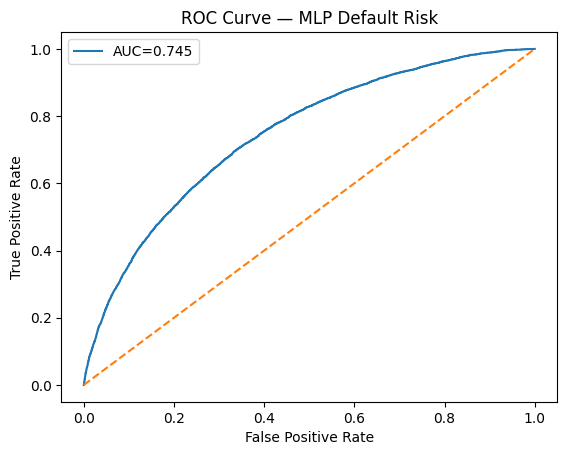

In [11]:
# ==== Cell 10: (Optional) ROC Curve Plot ====
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — MLP Default Risk")
plt.legend()
plt.show()
